In [1]:
%matplotlib inline

import os
import matplotlib.pyplot as plt
import healpy as hp
import pymaster as nmt
import numpy as np
from scipy.interpolate import interp1d
from astropy.io import fits

In [2]:
dir_planck = '/home/zgd/cmb_y/ver1/Planck/'
dir_unWISE = '/home/zgd/cmb_y/ver1/unWISE/'
dir_output = '/home/zgd/cmb_y/ver1/output/'

ymap_paths = os.listdir(dir_planck+'ymap/')
ymap_paths.sort()

ymap_mask_paths = os.listdir(dir_planck+'mask/')
ymap_mask_paths.sort()
print(ymap_mask_paths)



['COM_CompMap_Compton-SZMap-masks_2048_R2.01.fits', 'HFI_inpainting_bool.fits', 'LFI_inpainting_bool.fits', 'ymapv1_mask.fits']


In [3]:
NSIDE =2048

# Deal with alllll the masks and weights here

y_mask = hp.read_map('/home/zgd/cmb_y/ver1/Planck/mask/COM_CompMap_Compton-SZMap-masks_2048_R2.01.fits', field=1)
y_mask_LFI = hp.read_map('/home/zgd/cmb_y/ver1/Planck/mask/LFI_inpainting_bool.fits', field=0)
y_mask_HFI = hp.read_map('/home/zgd/cmb_y/ver1/Planck/mask/HFI_inpainting_bool.fits', field=0)

aposcale = 1.0
y_mask_HFI_apodized = nmt.mask_apodization(y_mask_HFI, aposcale, apotype='C1')
y_mask_LFI_apodized = nmt.mask_apodization(y_mask_LFI, aposcale, apotype='C1')
y_mask = y_mask_HFI_apodized*y_mask_LFI_apodized*y_mask

gal_mask = hp.read_map('/home/zgd/cmb_y/ver1/unWISE/mask/mask_unWISE_full_v10.fits', field=0)
weight0 = hp.read_map('/home/zgd/cmb_y/ver1/unWISE/weights/blue_w2_5sig_weights.fits')
weight1 = hp.read_map('/home/zgd/cmb_y/ver1/unWISE/weights/blue_star_weights.fits')
gal_weights = hp.ud_grade(weight0*weight1,NSIDE)

hdul = fits.open('/home/zgd/cmb_y/ver1/unWISE/loss/unmaskedareafrac-flag.fits')
gal_loss = hdul[0].data
hdul.close()


In [4]:
# aposcale = 0.5
# gal_mask_apodized = nmt.mask_apodization(gal_mask, aposcale, apotype='Smooth')

compton fsky=0.4197986133714097
combined fsky=0.3675711937488833


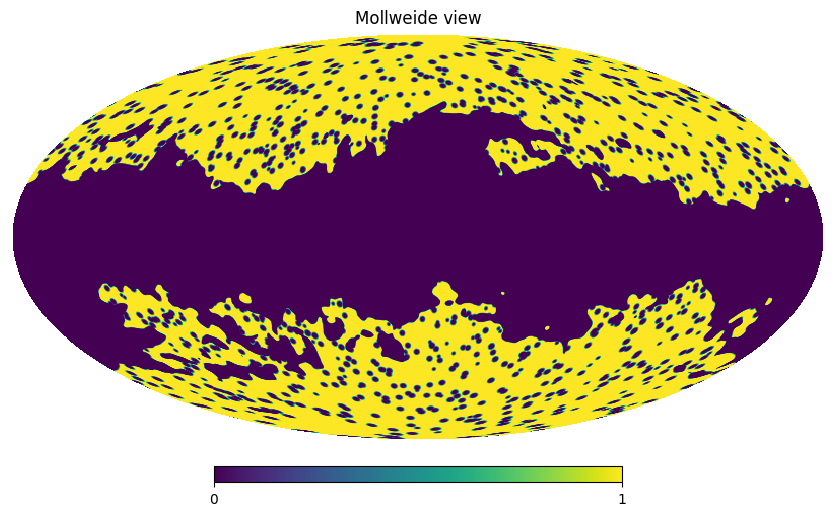

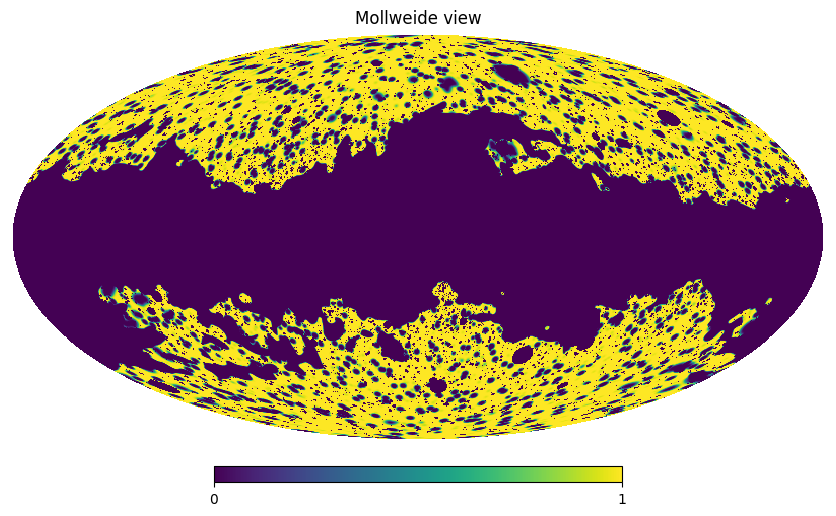

In [5]:
hp.mollview(y_mask)
print('compton fsky={}'.format(np.sum(y_mask)/(12*2048**2)))
# hp.mollview(gal_mask_apodized)
# print('galaxy fsky={}'.format(np.sum(gal_mask)/(12*2048**2)))
hp.mollview(gal_mask*y_mask)
print('combined fsky={}'.format(np.sum(gal_mask*y_mask)/(12*2048**2)))

In [7]:
def get_galaxy_map(path:str,weighted=True,masked=True,lossed=True,normed=False):

    print('reading map {}...'.format(path))
    if path.split('.')[-1] == 'fits':
        raw_map = hp.read_map(path, field=0)
    if path.split('.')[-1] == 'npy':
        raw_map = np.load(path)
    
    if weighted:
        print('weighting map...')
        raw_map = raw_map*gal_weights

    if masked:
        print('masking map...')
        raw_map = raw_map*gal_mask

    if lossed:
        print('compensating foreground loss...')
        raw_map = raw_map/gal_loss
        raw_map[gal_loss == 0] = 0
    
    if normed:
        print('normalizing...')
        eff_pix = np.sum(gal_mask)
        map_mean = np.sum(raw_map*gal_mask)/eff_pix
        overdensity = raw_map/map_mean - 1
        print('calculated fsky = {}'.format(eff_pix/np.shape(y_mask)[0]))
    else:
        print('skipped normalization...')
        overdensity = raw_map
    
    print('done.')
    return overdensity

In [8]:
np.seterr(divide='ignore', invalid='ignore')
#galaxy_density = get_galaxy_map('/home/zgd/cmb_y/ver1/unWISE/blue_count/map_count.npy',weighted=True)
galaxy_density = get_galaxy_map('/home/zgd/cmb_y/ver1/unWISE/blue/numcounts_map1_2048-r1-v2_flag.fits',masked=False,weighted=True,normed=True)
galaxy_w1 = get_galaxy_map('/home/zgd/cmb_y/ver1/unWISE/blue_w1_mean/map_w1_mean.npy',masked=False,weighted=True,normed=False)
galaxy_w2 = get_galaxy_map('/home/zgd/cmb_y/ver1/unWISE/blue_w2_mean/map_w2_mean.npy',masked=False,weighted=True,normed=False)
# galaxy_density_unweighted = get_galaxy_map('blue',weighted=False)
# galaxy_density_unlossed = get_galaxy_map('blue',weighted = True,lossed = 2.0)

reading map /home/zgd/cmb_y/ver1/unWISE/blue/numcounts_map1_2048-r1-v2_flag.fits...
weighting map...
compensating foreground loss...
normalizing...
calculated fsky = 0.5857119957605997
done.
reading map /home/zgd/cmb_y/ver1/unWISE/blue_w1_mean/map_w1_mean.npy...
weighting map...
compensating foreground loss...
skipped normalization...
done.
reading map /home/zgd/cmb_y/ver1/unWISE/blue_w2_mean/map_w2_mean.npy...
weighting map...
compensating foreground loss...
skipped normalization...
done.


In [9]:
galaxy_f     = nmt.NmtField(gal_mask, [galaxy_density])
print('galaxy f initialized.')
y_nodeproj_f = nmt.NmtField(y_mask, [hp.read_map('/home/zgd/cmb_y/ver1/Planck/ymap/no_deprojection_standard_full.fits')])
print('y f initialized.')
# y_CMB_f      = nmt.NmtField(y_mask, [hp.read_map('/home/zgd/cmb_y/ver1/Planck/ymap/deproject_CMB_standard_full.fits')])
# print('y CMB f initialized.')
# y_CMB_CIB_f  = nmt.NmtFIeld(y_mask, hp.read_map('/home/zgd/cmb_y/ver1/Planck/ymap/deproject_CMB_CIB_default_standard_full.fits'))
# print('y CMB CIB f initialized.')
# y_CMB_CIB_beta1_T24_f = nmt.NmtField(y_mask, hp.read_map('/home/zgd/cmb_y/ver1/Planck/ymap/SED/deproject_CMB_CIB_beta1.0_T24_standard_full.fits'))
# print('y CMB CIB beta1 T24 f initialized.')


galaxy f initialized.
y f initialized.


In [ ]:
nside = 2000
print('computing mode-coupling matrix...')
# Initialize binning scheme with 50 ells per bandpower
b = nmt.NmtBin.from_nside_linear(nside, 50)

# Compute MASTER estimator
# galaxy x galaxy
#cl_gg = nmt.compute_full_master(galaxy_f, galaxy_f, b)
#print('cl_gg computed.')
# y x galaxy

cl_gy_nodeproj = nmt.compute_full_master(galaxy_f, y_nodeproj_f, b)
print('nodeproj computed.')

In [ ]:
nside = 2000
print('computing mode-coupling matrix...')
# Initialize binning scheme with 50 ells per bandpower
b = nmt.NmtBin.from_nside_linear(nside, 50)

# Compute MASTER estimator
# galaxy x galaxy
#cl_gg = nmt.compute_full_master(galaxy_f, galaxy_f, b)
#print('cl_gg computed.')
# y x galaxy

cl_gy_nodeproj = nmt.compute_full_master(galaxy_f, y_nodeproj_f, b)
print('nodeproj computed.')
cl_gy_CMB = nmt.compute_full_master(galaxy_f, y_CMB_f, b)
print('CMB computed.')
# cl_gy_CMB_CIB = nmt.compute_full_master(galaxy_f, y_CMB_CIB_f, b)
# print('CMB CIB computed.')

# y x y
#cl_yy = nmt.compute_full_master(y_nodeproj_f, y_nodeproj_f, b)
#print('cl_yy computed.')

computing mode-coupling matrix...
nodeproj computed.
CMB computed.


In [70]:
y_CMB_CIB_beta1_4_T24_f = nmt.NmtField(y_mask, [hp.read_map('/home/zgd/cmb_y/ver1/Planck/ymap/SED/deproject_CMB_CIB_beta1.4_T10.14_standard_full.fits')])
print('y CMB CIB beta1.4 T24 f initialized.')
cl_gy_CMB_CIB_beta1_4_T24 = nmt.compute_full_master(galaxy_f, y_CMB_CIB_beta1_4_T24_f, b)
print('CMB CIB beta1.4 T24 computed.')
y_CMB_CIB_beta1_6_T24_f = nmt.NmtField(y_mask, [hp.read_map('/home/zgd/cmb_y/ver1/Planck/ymap/SED/deproject_CMB_CIB_beta1.6_T10.14_standard_full.fits')])
print('y CMB CIB beta1.6 T24 f initialized.')
cl_gy_CMB_CIB_beta1_6_T24 = nmt.compute_full_master(galaxy_f, y_CMB_CIB_beta1_6_T24_f, b)
print('CMB CIB beta1.6 T24 computed.')
y_CMB_CIB_beta1_4_T10_14_f = nmt.NmtField(y_mask, [hp.read_map('/home/zgd/cmb_y/ver1/Planck/ymap/SED/deproject_CMB_CIB_beta1.4_T10.14_standard_full.fits')])
print('y CMB CIB beta1.4 T10.24 f initialized.')
cl_gy_CMB_CIB_beta1_4_T10_14 = nmt.compute_full_master(galaxy_f, y_CMB_CIB_beta1_4_T10_14_f, b)
print('CMB CIB beta1.4 T10.24 computed.')
y_CMB_CIB_beta1_6_T10_14_f = nmt.NmtField(y_mask, [hp.read_map('/home/zgd/cmb_y/ver1/Planck/ymap/SED/deproject_CMB_CIB_beta1.6_T10.14_standard_full.fits')])
print('y CMB CIB beta1.6 T10.24 f initialized.')
cl_gy_CMB_CIB_beta1_6_T10_14 = nmt.compute_full_master(galaxy_f, y_CMB_CIB_beta1_6_T10_14_f, b)
print('CMB CIB beta1.6 T10.24 computed.')
y_CMB_CIB_beta1_9_T10_14_f = nmt.NmtField(y_mask, [hp.read_map('/home/zgd/cmb_y/ver1/Planck/ymap/SED/deproject_CMB_CIB_beta1.9_T10.14_standard_full.fits')])
print('y CMB CIB beta1.9 T10.24 f initialized.')
cl_gy_CMB_CIB_beta1_9_T10_14 = nmt.compute_full_master(galaxy_f, y_CMB_CIB_beta1_9_T10_14_f, b)
print('CMB CIB beta1.9 T10.24 computed.')

y CMB CIB beta1.4 T24 f initialized.
CMB CIB beta1.4 T24 computed.
y CMB CIB beta1.6 T24 f initialized.
CMB CIB beta1.6 T24 computed.
y CMB CIB beta1.4 T10.24 f initialized.
CMB CIB beta1.4 T10.24 computed.
y CMB CIB beta1.6 T10.24 f initialized.
CMB CIB beta1.6 T10.24 computed.
y CMB CIB beta1.9 T10.24 f initialized.
CMB CIB beta1.9 T10.24 computed.


In [68]:
y_CMB_CIB_f  = nmt.NmtField(y_mask, [hp.read_map('/home/zgd/cmb_y/ver1/Planck/ymap/deproject_CMB_CIB_default_standard_full.fits')])
print('y CMB CIB f initialized.')
y_CMB_CIB_beta1_T24_f = nmt.NmtField(y_mask, [hp.read_map('/home/zgd/cmb_y/ver1/Planck/ymap/SED/deproject_CMB_CIB_beta1.0_T24_standard_full.fits')])
print('y CMB CIB beta1 T24 f initialized.')
cl_gy_CMB_CIB = nmt.compute_full_master(galaxy_f, y_CMB_CIB_f, b)
print('CMB CIB computed.')
cl_gy_CMB_CIB_beta1_T24 = nmt.compute_full_master(galaxy_f, y_CMB_CIB_beta1_T24_f, b)
print('CMB CIB beta1 T24 computed.')

y CMB CIB f initialized.
y CMB CIB beta1 T24 f initialized.
CMB CIB computed.
CMB CIB beta1 T24 computed.


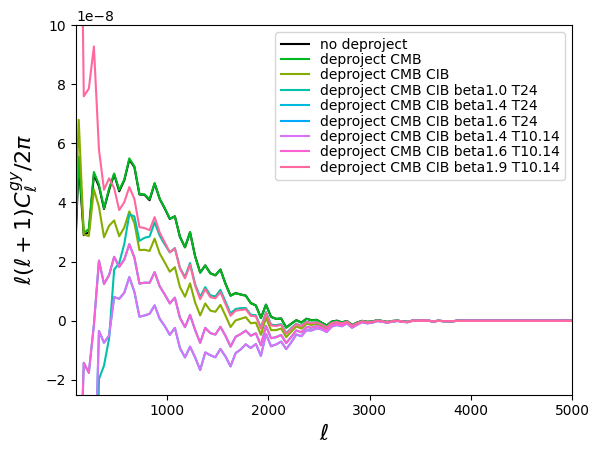

In [83]:
# Plot results
ell_arr = b.get_effective_ells()
#plt.plot(ell_arr, cl_gg[0], 'r-', label='gg')
#plt.plot(ell_arr, ell_arr*(ell_arr+1)*(cl_gg[0])/(2*np.pi), 'g-', label='gg')
plt.plot(ell_arr, ell_arr*(ell_arr+1)*cl_gy_nodeproj[0]/(2*np.pi), 'k', label='no deproject')
plt.plot(ell_arr, ell_arr*(ell_arr+1)*cl_gy_CMB[0]/(2*np.pi), '#00B81F', label='deproject CMB')
plt.plot(ell_arr, ell_arr*(ell_arr+1)*cl_gy_CMB_CIB[0]/(2*np.pi), '#85AD00', label='deproject CMB CIB')
plt.plot(ell_arr, ell_arr*(ell_arr+1)*cl_gy_CMB_CIB_beta1_T24[0]/(2*np.pi), '#00C1AA', label='deproject CMB CIB beta1.0 T24')
plt.plot(ell_arr, ell_arr*(ell_arr+1)*cl_gy_CMB_CIB_beta1_4_T24[0]/(2*np.pi), '#00BBDB', label='deproject CMB CIB beta1.4 T24')
plt.plot(ell_arr, ell_arr*(ell_arr+1)*cl_gy_CMB_CIB_beta1_6_T24[0]/(2*np.pi), '#00ABFD', label='deproject CMB CIB beta1.6 T24')
plt.plot(ell_arr, ell_arr*(ell_arr+1)*cl_gy_CMB_CIB_beta1_4_T10_14[0]/(2*np.pi), '#DC71FA', label='deproject CMB CIB beta1.4 T10.14')
plt.plot(ell_arr, ell_arr*(ell_arr+1)*cl_gy_CMB_CIB_beta1_6_T10_14[0]/(2*np.pi), '#FC61D5', label='deproject CMB CIB beta1.6 T10.14')
plt.plot(ell_arr, ell_arr*(ell_arr+1)*cl_gy_CMB_CIB_beta1_9_T10_14[0]/(2*np.pi), '#FF689F', label='deproject CMB CIB beta1.9 T10.14')
plt.xlim(100, 5000)
plt.ylim(-0.25e-7, 1e-7)
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$\\ell(\\ell+1)C_\\ell^{gy}/2\\pi$', fontsize=16)
plt.legend(loc='upper right', ncol=1, labelspacing=0.1)
plt.show()

In [84]:
dir_output = '/home/zgd/cmb_y/ver2/output/corr/bin/'
np.save(dir_output+'cl_gy_nodeproj.npy',cl_gy_nodeproj)
np.save(dir_output+'cl_gy_CMB.npy',cl_gy_CMB)
np.save(dir_output+'cl_gy_CMB_CIB.npy',cl_gy_CMB_CIB)
np.save(dir_output+'cl_gy_CMB_CIB_beta1_T24.npy',cl_gy_CMB_CIB_beta1_T24)
np.save(dir_output+'cl_gy_CMB_CIB_beta1_4_T24.npy',cl_gy_CMB_CIB_beta1_4_T24)
np.save(dir_output+'cl_gy_CMB_CIB_beta1_6_T24.npy',cl_gy_CMB_CIB_beta1_6_T24)
np.save(dir_output+'cl_gy_CMB_CIB_beta1_4_T10_14.npy',cl_gy_CMB_CIB_beta1_4_T10_14)
np.save(dir_output+'cl_gy_CMB_CIB_beta1_6_T10_14.npy',cl_gy_CMB_CIB_beta1_6_T10_14)
np.save(dir_output+'cl_gy_CMB_CIB_beta1_9_T10_14.npy',cl_gy_CMB_CIB_beta1_9_T10_14)

In [11]:
ymap_path_dict= {'no_deprojection':'/home/zgd/cmb_y/ver1/Planck/ymap/no_deprojection_standard_full.fits',
                 'CIB+CMB_default':'/home/zgd/cmb_y/ver1/Planck/ymap/deproject_CMB_CIB_default_standard_full.fits',
                 'CIB+CMB+dT+dbeta_default':'/home/zgd/cmb_y/ver1/Planck/ymap/deproject_CMB5_CIB_CIBdbeta_CIBdT_default_standard_full.fits',
                 'CIB+CMB_T=24_beta=1.0':'/home/zgd/cmb_y/ver1/Planck/ymap/SED/deproject_CMB_CIB_beta1.0_T24_standard_full.fits',
                 'CIB+CMB_T=24_beta=1.2':'/home/zgd/cmb_y/ver1/Planck/ymap/SED/deproject_CMB_CIB_beta1.2_T24_standard_full.fits',
                 'CIB+CMB_T=24_beta=1.4':'/home/zgd/cmb_y/ver1/Planck/ymap/SED/deproject_CMB_CIB_beta1.4_T24_standard_full.fits',
                 'CIB+CMB_T=24_beta=1.6':'/home/zgd/cmb_y/ver1/Planck/ymap/SED/deproject_CMB_CIB_beta1.6_T24_standard_full.fits',
                 'CIB+CMB_T=10.14_beta=1.4':'/home/zgd/cmb_y/ver1/Planck/ymap/SED/deproject_CMB_CIB_beta1.4_T10.14_standard_full.fits',
                 'CIB+CMB_T=10.14_beta=1.6':'/home/zgd/cmb_y/ver1/Planck/ymap/SED/deproject_CMB_CIB_beta1.6_T10.14_standard_full.fits',
                 'CIB+CMB_T=10.14_beta=1.9':'/home/zgd/cmb_y/ver1/Planck/ymap/SED/deproject_CMB_CIB_beta1.9_T10.14_standard_full.fits'}

ymap_path_dict_sample = {
                'no_deprojection':'/home/zgd/cmb_y/ver1/Planck/ymap/no_deprojection_standard_full.fits',
                'CIB+CMB_default':'/home/zgd/cmb_y/ver1/Planck/ymap/deproject_CMB_CIB_default_standard_full.fits',
                'CIB+CMB+dT+dbeta_default':'/home/zgd/cmb_y/ver1/Planck/ymap/deproject_CMB5_CIB_CIBdbeta_CIBdT_default_standard_full.fits'
}

In [12]:
Cut_comparison ={}

3.1411939736159966


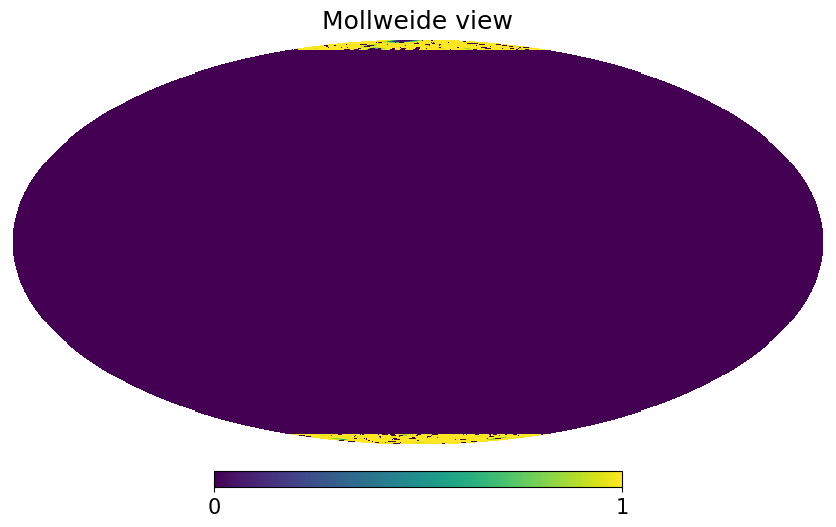

In [18]:
LMAX = 1000
BIN = 50
CUT = 0 #deg

#generate mask for the run
mask_cut = np.ones(12*2048**2)
pix_index = np.arange(12*2048**2)
theta,phi = hp.pix2ang(2048,pix_index)
print(np.max(theta))
mask_cut[pix_index[(theta<(90+CUT)/180*np.pi) &(theta>(90-CUT)/180*np.pi)]] = 0

mask_run = y_mask*mask_cut*gal_mask

hp.mollview(mask_run)

3.1411939736159966
fsky = 0.013171764406600882
reading map no_deprojection...
calculating angular power spectrum for no_deprojection...
calculating errors for no_deprojection...
plotting no_deprojection...
reading map CIB+CMB_default...
calculating angular power spectrum for CIB+CMB_default...
calculating errors for CIB+CMB_default...
plotting CIB+CMB_default...
reading map CIB+CMB+dT+dbeta_default...
calculating angular power spectrum for CIB+CMB+dT+dbeta_default...
calculating errors for CIB+CMB+dT+dbeta_default...
plotting CIB+CMB+dT+dbeta_default...


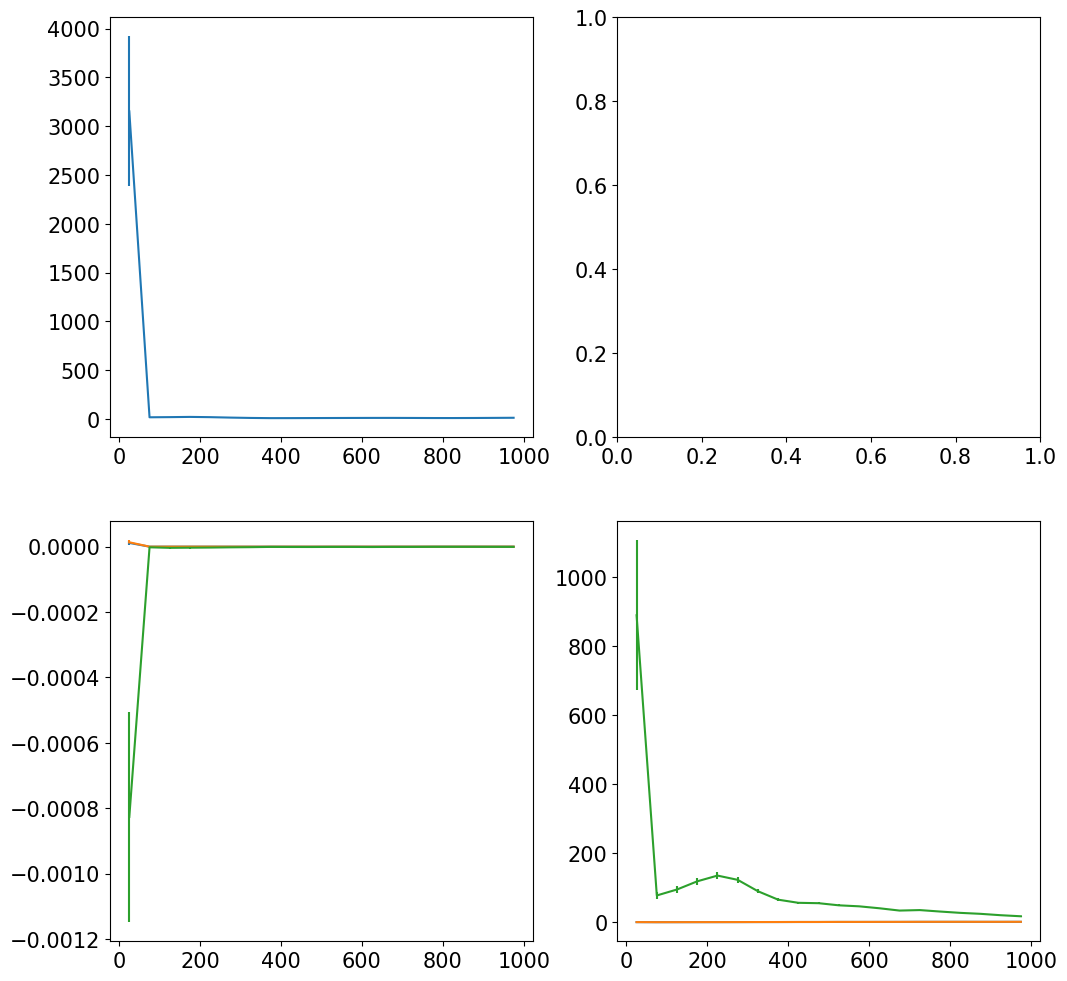

In [15]:
LMAX = 1000
BIN = 50
CUT = 80 #deg

#generate mask for the run
mask_cut = np.ones(12*2048**2)
pix_index = np.arange(12*2048**2)
theta,phi = hp.pix2ang(2048,pix_index)
print(np.max(theta))
mask_cut[pix_index[(theta<(90+CUT)/180*np.pi) &(theta>(90-CUT)/180*np.pi)]] = 0

mask_run = y_mask*mask_cut*gal_mask

f_sky = np.sum(mask_run)/np.shape(mask_run)[0]
print('fsky = {}'.format(f_sky))

#calculate angular power spectrum for galaxy density
ll = np.arange(LMAX//BIN)*BIN+0.5*BIN

ang_gg = hp.anafast(galaxy_density, lmax=LMAX,gal=CUT)
ang_gg_binned = np.mean(np.reshape(ang_gg[0:LMAX//BIN * BIN],(LMAX//BIN,BIN)),axis=1)
ang_gg_binned /= f_sky

sigma_gg = np.sqrt(2*(ang_gg_binned**2)/((2*ll+1)*BIN*f_sky))

fig,ax = plt.subplots(2,2,figsize=(12,12))
ax[0,0].errorbar(x=ll,y=ll*(ll+1)*ang_gg_binned/(2*np.pi),yerr=ll*(ll+1)*sigma_gg/(2*np.pi))

plot_data = {'fsky':f_sky,'gg':[ll,ang_gg_binned,sigma_gg]}

for model,path in ymap_path_dict_sample.items():
    
    print('reading map {}...'.format(model))

    ymap = hp.read_map(path)
    ymap_masked = mask_run*ymap

    print('calculating angular power spectrum for {}...'.format(model))

    ang_yy = hp.anafast(ymap_masked, lmax=LMAX,gal=CUT)
    ang_yy_binned = np.mean(np.reshape(ang_yy[0:LMAX//BIN * BIN],(LMAX//BIN,BIN)),axis=1)
    ang_yy_binned /= f_sky

    ang_gy = hp.anafast(map1 = ymap_masked, map2 = galaxy_density, lmax=LMAX,gal=CUT)
    ang_gy_binned = np.mean(np.reshape(ang_gy[0:LMAX//BIN * BIN],(LMAX//BIN,BIN)),axis=1)
    ang_gy_binned /= f_sky
    
    print('calculating errors for {}...'.format(model))

    sigma_gy = np.sqrt((ang_gg_binned*ang_yy_binned+ang_gy_binned**2)/((2*ll+1)*BIN*f_sky))
    sigma_yy = np.sqrt(2*(ang_yy_binned**2)/((2*ll+1)*BIN*f_sky))

    plot_data.update({model+'yy':[ll,ang_yy_binned,sigma_yy]})
    plot_data.update({model+'gy':[ll,ang_gy_binned,sigma_gy]})

    print('plotting {}...'.format(model))
    ax[1,0].errorbar(x=ll,y=ll*(ll+1)*ang_gy_binned/(2*np.pi),
                     yerr=ll*(ll+1)*sigma_gy/(2*np.pi))
    ax[1,1].errorbar(x=ll,y=1E12*ll*(ll+1)*ang_yy_binned/(2*np.pi),
                     yerr=1E12*ll*(ll+1)*sigma_yy/(2*np.pi),
                     label=model)

Cut_comparison.update({CUT:plot_data})

# ax[0,0].set_yscale('log')
# ax[0,0].set_xlabel('$\\ell$')
# ax[0,0].set_xlim(LMAX/10,LMAX)
# ax[0,0].set_ylabel('$\\ell(\\ell+1)C_\\ell^{gg}/2\\pi$')
# ax[0,0].set_ylim(0,0.1)

# ax[1,0].set_xlabel('$\\ell$')
# ax[1,0].set_xlim(LMAX/10,LMAX)
# ax[1,0].set_ylabel('$\\ell(\\ell+1)C_\\ell^{gy}/2\\pi$')
# ax[1,0].set_ylim(-1E-6,1E-6)

# ax[1,1].set_yscale('log')
# ax[1,1].set_xlabel('$\\ell$')
# ax[1,1].set_xlim(LMAX/10,LMAX)
# ax[1,1].set_ylabel('$10^{12}\\ell(\\ell+1)C_\\ell^{yy}/2\\pi$')
# ax[1,1].set_ylim(0,1)

# ax[0,1].set_axis_off()
#place the legend of the figure in the 0,1 subplot
# fig.legend(loc='upper right')
#fig.savefig('Sed_corss_spec.png')

In [16]:
print(Cut_comparison[30]['fsky'])
print(Cut_comparison[60]['fsky'])
print(Cut_comparison[80]['fsky'])

Cut_fskys ={30:0.353, 60:0.114, 80:0.013}
Cut_lines = {30:'-', 60:'--', 80:':'}
model_colors = {'no_deprojection':'b','CIB+CMB_default':'g'}

0.3528382486947843
0.11442728999259823
0.013171764406600882


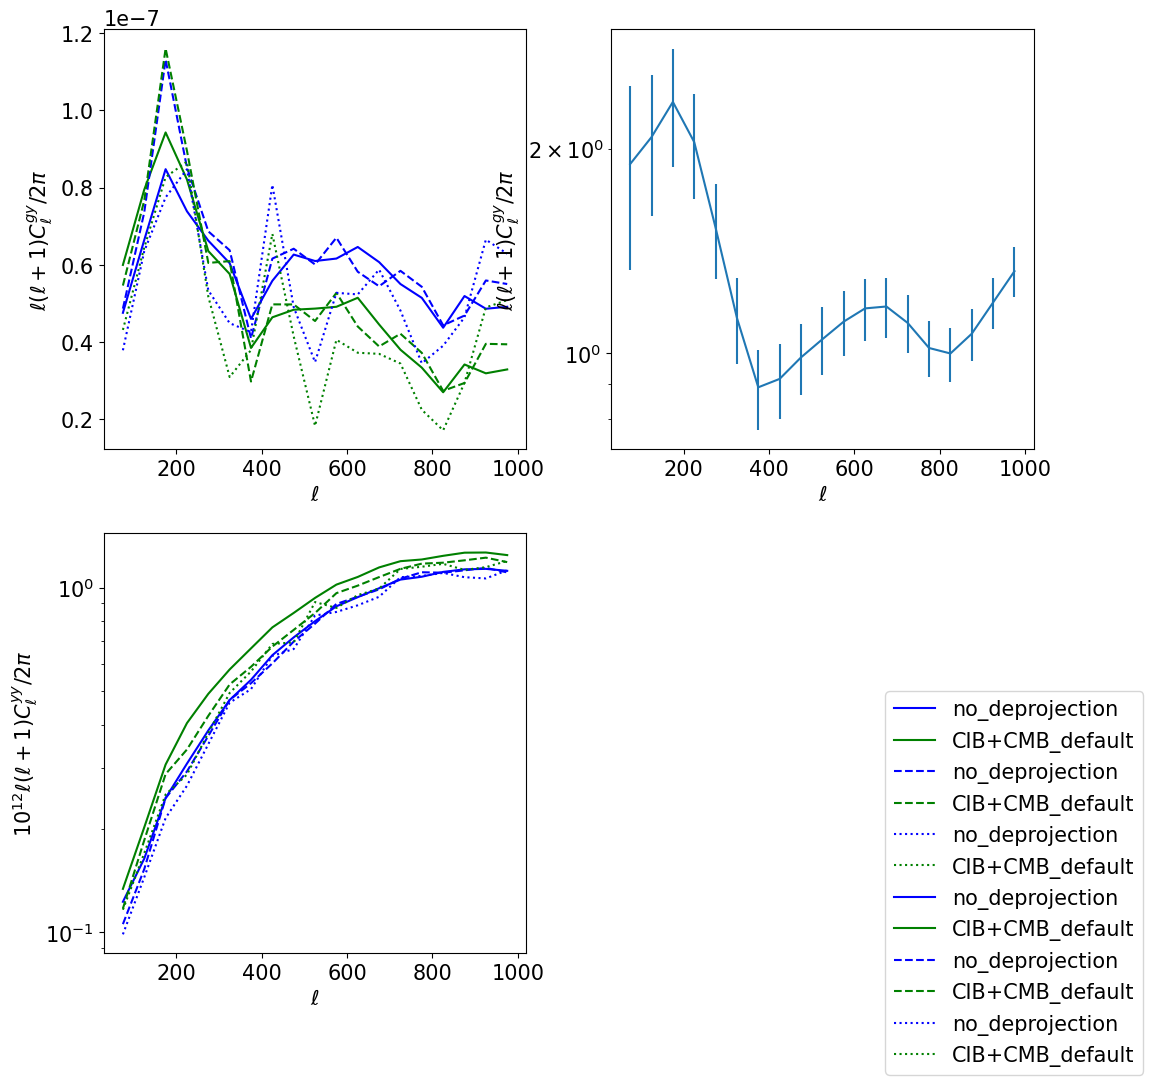

In [19]:

[ll,ang_gg_binned,sigma_gg] = Cut_comparison[60]['gg']
ll = ll[1:]
ang_gg_binned = ang_gg_binned[1:]
sigma_gg = sigma_gg[1:]

fig,ax = plt.subplots(2,2,figsize=(12,12))

ax[0,1].errorbar(ll,ll*(ll+1)*ang_gg_binned/(2*np.pi),yerr = ll*(ll+1)*sigma_gg)
ax[0,1].set_ylabel('$\\ell(\\ell+1)C_\\ell^{gy}/2\\pi$')
ax[0,1].set_xlabel('$\\ell$')
ax[0,1].set_yscale('log')

ymap_plot =['no_deprojection','CIB+CMB_default']

for cut,fsky in Cut_fskys.items():
    for model in ymap_plot:
        [ll,ang_gy_binned,sigma_gy] = Cut_comparison[cut][model+'gy']
        [ll,ang_yy_binned,sigma_yy] = Cut_comparison[cut][model+'yy']

        ll = ll[1:]
        ang_gy_binned = ang_gy_binned[1:]
        sigma_gy = sigma_gy[1:]
        ang_yy_binned = ang_yy_binned[1:]
        sigma_yy = sigma_yy[1:]

        ax[0,0].plot(ll,ll*(ll+1)*ang_gy_binned/(2*np.pi),label=model,ls=Cut_lines[cut],c = model_colors[model])
        ax[0,0].set_ylabel('$\\ell(\\ell+1)C_\\ell^{gy}/2\\pi$')
        ax[0,0].set_xlabel('$\\ell$')

        ax[1,0].plot(ll,1E12*ll*(ll+1)*ang_yy_binned/(2*np.pi),label=model,ls=Cut_lines[cut],c = model_colors[model])
        ax[1,0].set_ylabel('$10^{12}\\ell(\\ell+1)C_\\ell^{yy}/2\\pi$')
        ax[1,0].set_xlabel('$\\ell$')

ax[1,1].axis('off')
ax[1,0].set_yscale('log')
fig.legend(loc='lower right')



3.1411939736159966


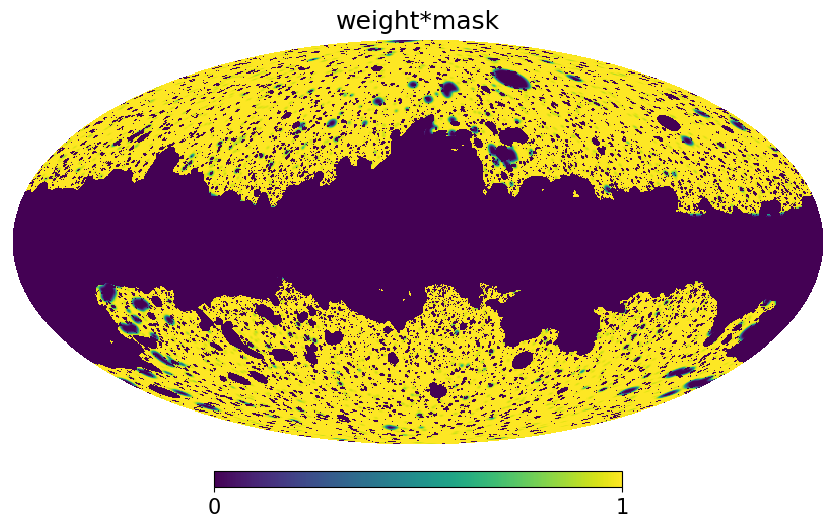

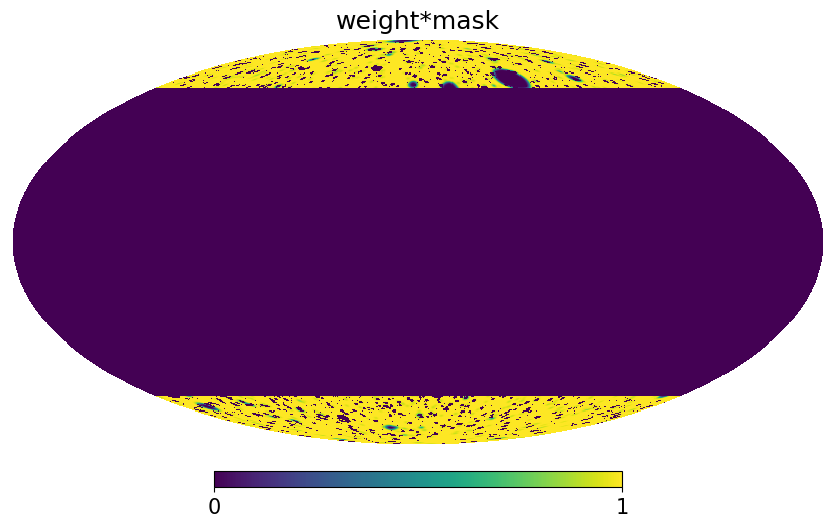

In [53]:
CUT = 60 #deg

mask_cut = np.ones(12*2048**2)
#turn all indiciess inside the cut to 0
pix_index = np.arange(12*2048**2)
theta,phi = hp.pix2ang(2048,pix_index)
print(np.max(theta))
mask_cut[pix_index[(theta<(90+CUT)/180*np.pi) &(theta>(90-CUT)/180*np.pi)]] = 0

hp.mollview(gal_mask*y_mask,title='weight*mask')
hp.mollview(gal_mask*y_mask*mask_cut,title='weight*mask')

In [54]:
gal_mask = hp.read_map(dir_unWISE+'mask/'+galaxy_mask_path)
y_mask = hp.read_map(dir_planck+'mask/'+LFI_mask_path)

galaxy_density = galaxy_density_weighted

LMAX = 1000
BIN = 50

f_sky_cut = np.sum(gal_mask*y_mask*mask_cut)/np.shape(y_mask)[0]
print('fsky_cut = {}'.format(f_sky_cut))

ll = np.arange(LMAX//BIN)*BIN+0.5*BIN

ang_gg = hp.anafast(galaxy_density, lmax=LMAX,gal_cut= CUT)
ang_gg_binned = np.mean(np.reshape(ang_gg[0:LMAX//BIN * BIN],(LMAX//BIN,BIN)),axis=1)
ang_gg_binned /= f_sky_cut

results = []
errs = []
legends = []

for metadata in sample_metadata_list:

    ymap = hp.read_map(metadata.path)
    ymap_masked = ymap*gal_mask*y_mask*mask_cut
    
    ang_yy = hp.anafast(ymap_masked, lmax=LMAX,gal_cut= CUT)
    ang_yy_binned = np.mean(np.reshape(ang_yy[0:LMAX//BIN * BIN],(LMAX//BIN,BIN)),axis=1)
    ang_yy_binned /= f_sky_cut
    ang_gy = hp.anafast(map1 = ymap_masked, map2 = galaxy_density, lmax=LMAX,gal_cut= CUT)
    ang_gy_binned = np.mean(np.reshape(ang_gy[0:LMAX//BIN * BIN],(LMAX//BIN,BIN)),axis=1)
    ang_gy_binned /= f_sky_cut

    sigma_gy = np.sqrt((ang_gg_binned*ang_yy_binned+ang_gy_binned**2)/((2*ll+1)*BIN*f_sky_cut))

    results.append(ang_gy_binned)
    errs.append(sigma_gy)
    legends.append('$T={},\\beta = {},gal_cut={}$'.format(metadata.temp,metadata.beta,CUT))

np.save('results{}.npy'.format(CUT),np.array(results))
np.save('errs{}.npy'.format(CUT),np.array(errs))
np.save('legends{}.npy'.format(CUT),np.array(legends))


fsky_cut = 0.11492629799686482


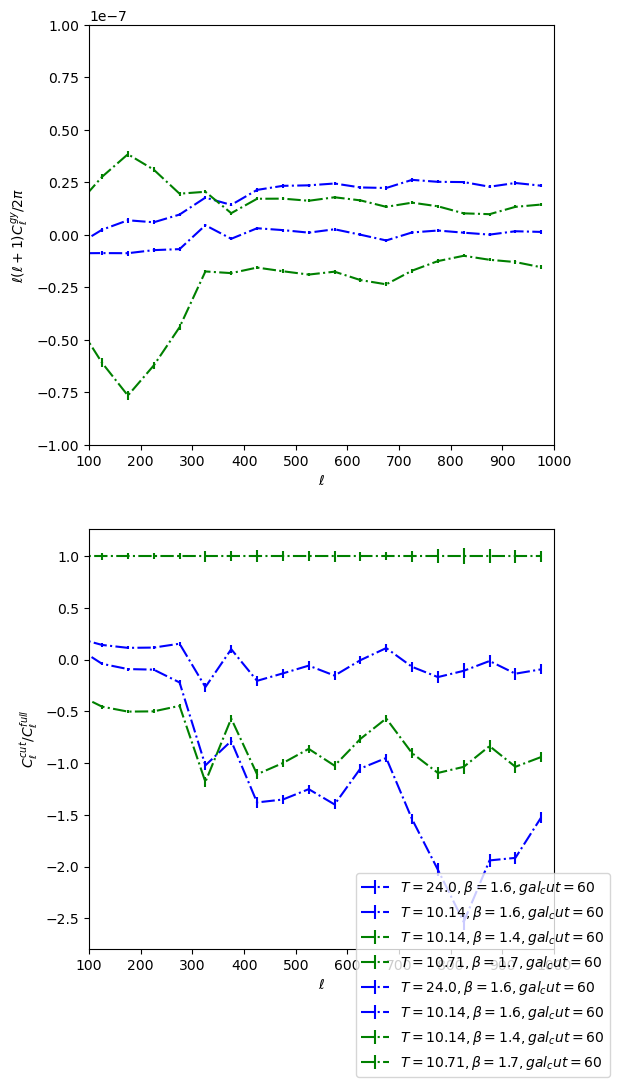

In [63]:
# fig,ax = plt.subplots(2,figsize=(6,12))
# colors = ['b','g','r','k']

# for i in range(len(results)):
#     ax[1].errorbar(x=ll,y=results[i]/results[-2],
#                     yerr=errs[i]/results[-2],
#                     label=legends[i],ls='-.'if 'gal_cut' in legends[i] else '-',c=colors[i//2])
#     ax[0].errorbar(x=ll,y=ll*(ll+1)*results[i]/(2*np.pi),
#                     yerr=ll*(ll+1)*errs[i]/(2*np.pi),
#                     label=legends[i],ls='-.'if 'gal_cut' in legends[i] else '-',c=colors[i//2])

# ax[0].set_xlabel('$\\ell$')
# ax[0].set_xlim(LMAX/10,LMAX)
# ax[0].set_ylabel('$\\ell(\\ell+1)C_\\ell^{gy}/2\\pi$')
# ax[0].set_ylim(-1E-7,1E-7)

# ax[1].set_xlabel('$\\ell$')
# ax[1].set_xlim(LMAX/10,LMAX)
# ax[1].set_ylabel('$C_\\ell^{cut}/C_\\ell^{full}$')

# #place the legend of the figure in the 0,1 subplot
# fig.legend(loc='lower right')
# fig.savefig('galcut_comparison.png')

In [55]:
results85 = np.load('results85.npy')
errs85 = np.load('errs85.npy')
legends85 = np.load('legends85.npy')

results60 = np.load('results60.npy')
errs60 = np.load('errs60.npy')
legends60 = np.load('legends60.npy')

results0 = np.load('results0.npy')
errs0 = np.load('errs0.npy')
legends0 = np.load('legends0.npy')


In [29]:
print(np.mean(errs60[1]))
print(np.mean(errs60[5]))

plt.plot(errs60)

8.652924399689959e-10
1.7053195927965986e-11


NameError: name 'err60' is not defined

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


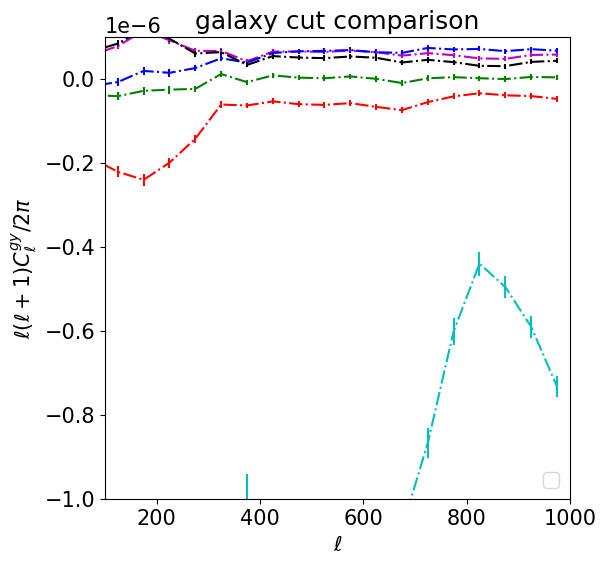

In [57]:
fig,ax = plt.subplots(figsize=(6,6))
colors = ['m','c','b','g','r','k']
legends = ['no deprojection','$dT d\\beta$','$T=24.0,\\beta=1.6$','$T=10.14,\\beta=1.6$','$T=10.14,\\beta=1.4$','$T=10.71,\\beta=1.7$']

for i in range(6):
    # ax.errorbar(x=ll,y=results0[i]/results0[i],yerr=errs0[i]/results0[i],label=legends0[i][0:-3],ls='-',c=colors[i])
    # ax.errorbar(x=ll,y=results30[i]/results0[i],yerr=errs30[i]/results0[i],ls='-.',c=colors[i])
    # ax.errorbar(x=ll,y=results60[i]/results0[i],yerr=errs60[i]/results0[i],ls=':',c=colors[i])
    #ax.errorbar(x=ll,y=ll*(ll+1)*results0[i]/(2*np.pi),yerr=ll*(ll+1)*errs0[i]/(2*np.pi),c=colors[i],label=legends[i])
    #ax.errorbar(x=ll,y=ll*(ll+1)*results30[i]/(2*np.pi),yerr=ll*(ll+1)*errs30[i]/(2*np.pi),ls='--',c=colors[i])
    ax.errorbar(x=ll,y=ll*(ll+1)*results60[i]/(2*np.pi),yerr=ll*(ll+1)*errs60[i]/(2*np.pi),ls='-.',c=colors[i])
    #ax.errorbar(x=ll,y=ll*(ll+1)*results85[i]/(2*np.pi),yerr=ll*(ll+1)*errs85[i]/(2*np.pi),ls=':',c=colors[i])


ax.set_xlabel('$\\ell$')
ax.set_xlim(LMAX/10,LMAX)
ax.set_ylabel('$\\ell(\\ell+1)C_\\ell^{gy}/2\\pi$')
ax.set_ylim(-1E-6,1E-7)

# ax[1].set_xlabel('$\\ell$')
# ax[1].set_xlim(LMAX/10,LMAX)
# ax[1].set_ylabel('$C_\\ell^{cut}/C_\\ell^{full}$')
# ax[1].set_ylim(0.5,1.5)

#place the legend of the figure in the 0,1 subplot
ax.legend(loc='lower right')
ax.set_title('galaxy cut comparison')
fig.savefig('galcut_comparison.png',dpi=400)

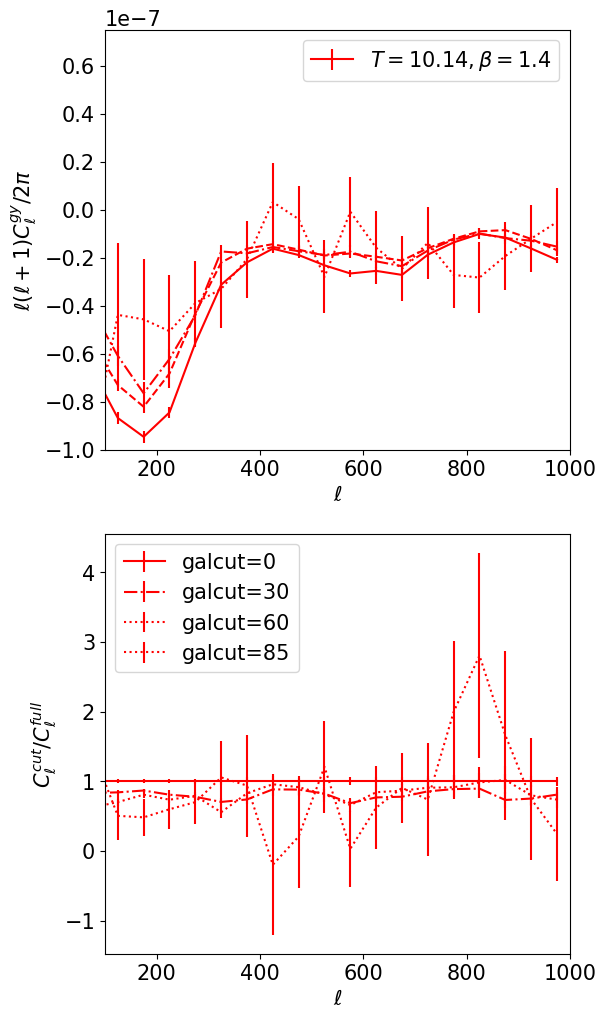

In [36]:
fig,ax = plt.subplots(2,figsize=(6,12))
colors = ['m','c','b','g','r','k']
labels = ['galcut=0','galcut=30','galcut=60','galcut=85']

for i in range(4,5):
    ax[1].errorbar(x=ll,y=results0[i]/results0[i],yerr=errs0[i]/results0[i],ls='-',c=colors[i],label=labels[0])
    ax[1].errorbar(x=ll,y=results30[i]/results0[i],yerr=errs30[i]/results0[i],ls='-.',c=colors[i],label=labels[1])
    ax[1].errorbar(x=ll,y=results60[i]/results0[i],yerr=errs60[i]/results0[i],ls=':',c=colors[i],label=labels[2])
    ax[1].errorbar(x=ll,y=results85[i]/results0[i],yerr=errs85[i]/results0[i],ls=':',c=colors[i],label=labels[3])
    ax[0].errorbar(x=ll,y=ll*(ll+1)*results0[i]/(2*np.pi),yerr=ll*(ll+1)*errs0[i]/(2*np.pi),c=colors[i],label=legends[i])
    ax[0].errorbar(x=ll,y=ll*(ll+1)*results30[i]/(2*np.pi),yerr=ll*(ll+1)*errs30[i]/(2*np.pi),ls='--',c=colors[i])
    ax[0].errorbar(x=ll,y=ll*(ll+1)*results60[i]/(2*np.pi),yerr=ll*(ll+1)*errs60[i]/(2*np.pi),ls='-.',c=colors[i])
    ax[0].errorbar(x=ll,y=ll*(ll+1)*results85[i]/(2*np.pi),yerr=ll*(ll+1)*errs85[i]/(2*np.pi),ls=':',c=colors[i])


ax[0].set_xlabel('$\\ell$')
ax[0].set_xlim(LMAX/10,LMAX)
ax[0].set_ylabel('$\\ell(\\ell+1)C_\\ell^{gy}/2\\pi$')
ax[0].set_ylim(-1E-7,0.75E-7)


ax[1].set_xlabel('$\\ell$')
ax[1].set_xlim(LMAX/10,LMAX)
ax[1].set_ylabel('$C_\\ell^{cut}/C_\\ell^{full}$')
#ax[1].set_ylim(0.6,1.6)

#place the legend of the figure in the 0,1 subplot
ax[0].legend()
ax[1].legend()
#fig.savefig('galcut_comparison_default.png')